In [5]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [6]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.

  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.

  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person


fatal: destination path 'examples' already exists and is not an empty directory.


In [7]:
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.

  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.

  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np


In [8]:
class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""

  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0

        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)

          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)

          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df


# Concatanating Train CSVs

In [48]:
file1_path = '/kaggle/input/preprocessed-aii2022-data-human-pose-estimation/train_data.csv'
file2_path = '/kaggle/input/preprocessed-aii2022-data-human-pose-estimation/train_data(1).csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

In [49]:
df2['class_no'] = df2['class_no'].replace(range(40), range(40, 80))


In [50]:
df2['class_no'].unique()

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79])

In [51]:
combined_df = pd.concat([df1, df2], ignore_index=True)

output_file_path = output_csv_path
combined_df.to_csv(output_file_path, index=False)

In [52]:
train = pd.read_csv('train_combo.csv')

In [53]:
train

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name
0,2_10_19/00450.jpg,687.0,590.0,0.572590,697.0,569.0,0.468765,668.0,576.0,0.613829,...,679.0,0.168971,1022.0,642.0,0.456951,1022.0,645.0,0.404843,0,2_10_19
1,2_10_19/00622.jpg,592.0,485.0,0.494089,622.0,455.0,0.664040,565.0,455.0,0.620777,...,397.0,0.442584,830.0,435.0,0.262815,483.0,577.0,0.373167,0,2_10_19
2,2_10_19/02663.jpg,513.0,209.0,0.776050,550.0,198.0,0.777749,506.0,173.0,0.828386,...,225.0,0.251508,175.0,204.0,0.491063,179.0,198.0,0.140166,0,2_10_19
3,2_10_19/06491.jpg,160.0,104.0,0.795086,169.0,95.0,0.853604,151.0,92.0,0.850290,...,146.0,0.540147,321.0,134.0,0.335968,324.0,135.0,0.537511,0,2_10_19
4,2_10_19/06968.jpg,455.0,219.0,0.655691,476.0,195.0,0.834567,436.0,194.0,0.793879,...,179.0,0.597197,136.0,271.0,0.452331,161.0,240.0,0.239239,0,2_10_19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333,2_9_24/70465.jpg,453.0,364.0,0.410221,454.0,354.0,0.744231,454.0,355.0,0.672778,...,385.0,0.318389,429.0,409.0,0.507837,431.0,407.0,0.662795,79,2_9_24
10334,2_9_24/70555.jpg,975.0,275.0,0.654593,988.0,255.0,0.881551,958.0,258.0,0.910120,...,331.0,0.680367,1184.0,205.0,0.877857,776.0,207.0,0.928452,79,2_9_24
10335,2_9_24/70915.jpg,212.0,329.0,0.809593,225.0,321.0,0.932292,210.0,320.0,0.864204,...,386.0,0.309849,297.0,316.0,0.331828,120.0,306.0,0.702162,79,2_9_24
10336,2_9_24/73901.jpg,109.0,153.0,0.572565,112.0,146.0,0.612478,108.0,146.0,0.523025,...,168.0,0.545832,196.0,186.0,0.264087,56.0,165.0,0.755228,79,2_9_24


In [54]:
train['class_no'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [55]:
train.shape

(10338, 54)

In [56]:
is_skip_step_1 = False

# Model Training Setup

In [57]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.

  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(output_file_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe


In [58]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(output_file_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)


In [59]:
X

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,LEFT_KNEE_score,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score
0,687.0,590.0,0.572590,697.0,569.0,0.468765,668.0,576.0,0.613829,708.0,...,0.167868,815.0,679.0,0.168971,1022.0,642.0,0.456951,1022.0,645.0,0.404843
1,592.0,485.0,0.494089,622.0,455.0,0.664040,565.0,455.0,0.620777,674.0,...,0.260709,450.0,397.0,0.442584,830.0,435.0,0.262815,483.0,577.0,0.373167
2,513.0,209.0,0.776050,550.0,198.0,0.777749,506.0,173.0,0.828386,589.0,...,0.559961,308.0,225.0,0.251508,175.0,204.0,0.491063,179.0,198.0,0.140166
3,160.0,104.0,0.795086,169.0,95.0,0.853604,151.0,92.0,0.850290,178.0,...,0.489246,248.0,146.0,0.540147,321.0,134.0,0.335968,324.0,135.0,0.537511
4,455.0,219.0,0.655691,476.0,195.0,0.834567,436.0,194.0,0.793879,497.0,...,0.333171,321.0,179.0,0.597197,136.0,271.0,0.452331,161.0,240.0,0.239239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333,453.0,364.0,0.410221,454.0,354.0,0.744231,454.0,355.0,0.672778,475.0,...,0.259912,523.0,385.0,0.318389,429.0,409.0,0.507837,431.0,407.0,0.662795
10334,975.0,275.0,0.654593,988.0,255.0,0.881551,958.0,258.0,0.910120,1006.0,...,0.858145,856.0,331.0,0.680367,1184.0,205.0,0.877857,776.0,207.0,0.928452
10335,212.0,329.0,0.809593,225.0,321.0,0.932292,210.0,320.0,0.864204,254.0,...,0.570334,199.0,386.0,0.309849,297.0,316.0,0.331828,120.0,306.0,0.702162
10336,109.0,153.0,0.572565,112.0,146.0,0.612478,108.0,146.0,0.523025,129.0,...,0.265237,120.0,168.0,0.545832,196.0,186.0,0.264087,56.0,165.0,0.755228


In [60]:
np.unique(y)

array([0., 1.], dtype=float32)

In [61]:
len(next(os.walk('/kaggle/input/preprocessed-aii2022-data-human-pose-estimation/output_train_combo/output_train_combo'))[1])


80

In [62]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(8787, 51)
(1551, 51)
(8787, 80)
(1551, 80)


In [63]:
test_path = '/kaggle/input/preprocessed-aii2022-data-human-pose-estimation/test_data.csv'

In [64]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(test_path)


In [65]:
print(X_test.shape)
print(y_test.shape)

(10338, 51)
(10338, 80)


In [66]:
# print(y_train.head())

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [67]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding


# Defining our Pose Classifier Model

In [68]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

# Compilation and Training

In [69]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/200
524/550 [===========================>..] - ETA: 0s - loss: 3.9173 - accuracy: 0.0810
Epoch 1: val_accuracy improved from -inf to 0.19729, saving model to weights.best.hdf5
550/550 [==============================] - 3s 3ms/step - loss: 3.8992 - accuracy: 0.0836 - val_loss: 3.3500 - val_accuracy: 0.1973
Epoch 2/200
547/550 [============================>.] - ETA: 0s - loss: 3.2588 - accuracy: 0.1668
Epoch 2: val_accuracy improved from 0.19729 to 0.29142, saving model to weights.best.hdf5
550/550 [==============================] - 1s 2ms/step - loss: 3.2570 - accuracy: 0.1666 - val_loss: 2.7943 - val_accuracy: 0.2914
Epoch 3/200
536/550 [============================>.] - ETA: 0s - loss: 2.8869 - accuracy: 0.2271
Epoch 3: val_accuracy improved from 0.29142 to 0.38233, saving model to weights.best.hdf5
550/550 [==============================] - 1s 2ms/step - loss: 2.8806 - accuracy: 0.2287 - val_loss: 2.4463 - val_accuracy: 0.3823
Epoch 4/200
550/550 [============================

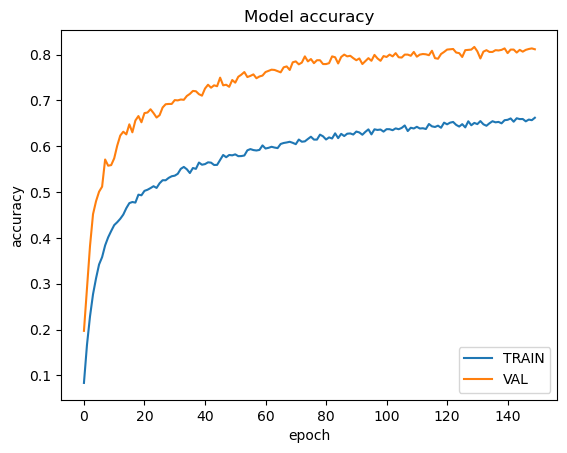

In [70]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()


In [71]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)


324/324 [==============================] - 0s 1ms/step - loss: 0.7521 - accuracy: 0.8160


324/324 [==============================] - 1s 1ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

      0_0_18       0.71      0.87      0.78       162
      0_0_68       0.74      0.93      0.83       169
       0_0_8       0.85      0.82      0.84       178
      0_1_16       1.00      0.05      0.09        44
      0_1_17       0.72      0.92      0.81       178
      0_1_36       0.86      0.66      0.75        96
      0_1_60       0.80      0.94      0.86       234
      0_1_77       0.86      0.88      0.87       144
      0_2_21       0.86      0.90      0.88       317
      0_2_22       0.83      0.96      0.89       309
      0_2_29       0.97      0.92      0.94        91
      0_2_31       0.94      0.86      0.90       143
      0_2_40       0.85      0.55      0.67       148
      0_2_75       0.79      0.91      0.85       102
      0_3_39       0.87      0.89      0.88       211
      0_3_61   

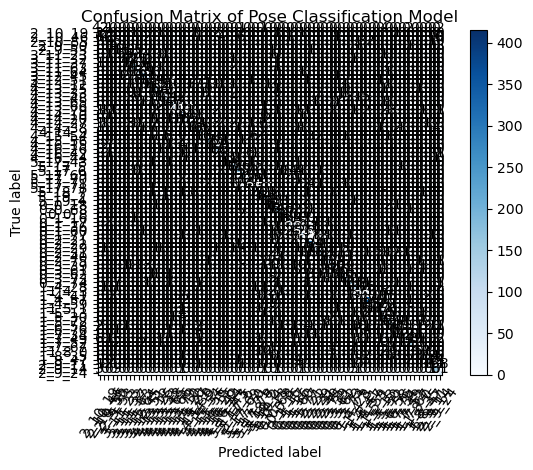

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))


In [76]:
df_test

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name
0,2_10_19/00450.jpg,687.0,590.0,0.572590,697.0,569.0,0.468765,668.0,576.0,0.613829,...,679.0,0.168971,1022.0,642.0,0.456951,1022.0,645.0,0.404843,0,2_10_19
1,2_10_19/00622.jpg,592.0,485.0,0.494089,622.0,455.0,0.664040,565.0,455.0,0.620777,...,397.0,0.442584,830.0,435.0,0.262815,483.0,577.0,0.373167,0,2_10_19
2,2_10_19/02663.jpg,513.0,209.0,0.776050,550.0,198.0,0.777749,506.0,173.0,0.828386,...,225.0,0.251508,175.0,204.0,0.491063,179.0,198.0,0.140166,0,2_10_19
3,2_10_19/06491.jpg,160.0,104.0,0.795086,169.0,95.0,0.853604,151.0,92.0,0.850290,...,146.0,0.540147,321.0,134.0,0.335968,324.0,135.0,0.537511,0,2_10_19
4,2_10_19/06968.jpg,455.0,219.0,0.655691,476.0,195.0,0.834567,436.0,194.0,0.793879,...,179.0,0.597197,136.0,271.0,0.452331,161.0,240.0,0.239239,0,2_10_19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333,2_9_24/70465.jpg,453.0,364.0,0.410221,454.0,354.0,0.744231,454.0,355.0,0.672778,...,385.0,0.318389,429.0,409.0,0.507837,431.0,407.0,0.662795,79,2_9_24
10334,2_9_24/70555.jpg,975.0,275.0,0.654593,988.0,255.0,0.881551,958.0,258.0,0.910120,...,331.0,0.680367,1184.0,205.0,0.877857,776.0,207.0,0.928452,79,2_9_24
10335,2_9_24/70915.jpg,212.0,329.0,0.809593,225.0,321.0,0.932292,210.0,320.0,0.864204,...,386.0,0.309849,297.0,316.0,0.331828,120.0,306.0,0.702162,79,2_9_24
10336,2_9_24/73901.jpg,109.0,153.0,0.572565,112.0,146.0,0.612478,108.0,146.0,0.523025,...,168.0,0.545832,196.0,186.0,0.264087,56.0,165.0,0.755228,79,2_9_24


[ WARN:0@4452.060] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/preprocessed-aii2022-data-human-pose-estimation/output_test/Test/2_10_19/02663.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


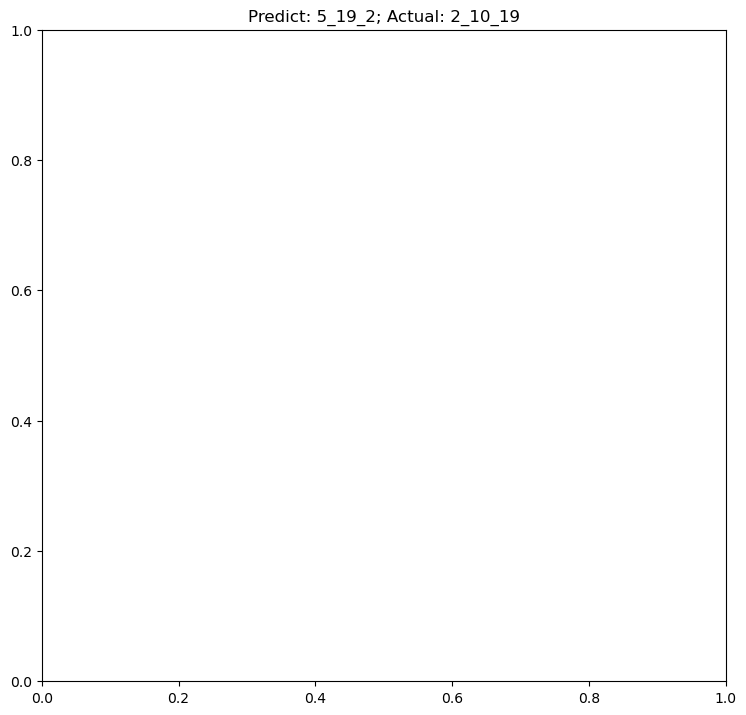

In [75]:
images_out_test_folder = '/kaggle/input/preprocessed-aii2022-data-human-pose-estimation/output_test/Test'
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
